In [1]:
import glob
import pandas as pd
catfs = glob.glob("train/train/cat.*.jpg")
catt = [0] * len(catfs)
dogfs = glob.glob("train/train/dog.*.jpg")
dogt = [1] * len(dogfs)
df = pd.DataFrame({
    "path":catfs + dogfs,
    "ans":catt + dogt
})
df

,path,ans
0,train/train\cat.0.jpg,0
1,train/train\cat.1.jpg,0
2,train/train\cat.10.jpg,0
3,train/train\cat.100.jpg,0
4,train/train\cat.1000.jpg,0
...,...,...
24995,train/train\dog.9995.jpg,1
24996,train/train\dog.9996.jpg,1
24997,train/train\dog.9997.jpg,1
24998,train/train\dog.9998.jpg,1


In [2]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Using TensorFlow backend.
C:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

In [3]:
vgg.layers

In [4]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
# trainable一定要在compile前
for l in vgg.layers:
    l.trainable = False
x = BatchNormalization()(vgg.output)
# MLP
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.25)(x)
out = Dense(2, activation="softmax")(x)
model = Model(inputs=vgg.input, outputs=out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [5]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [6]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
import numpy as np
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input
p = df.iloc[0]["path"]
img = load_img(p, target_size=(224, 224)).convert("RGB")
img_np = np.array(img)
img_pre = preprocess_input(img_np)
img_pre

array([[[ -16.939003 ,   47.221    ,   79.32     ],
        [ -13.939003 ,   50.221    ,   82.32     ],
        [ -10.939003 ,   53.221    ,   85.32     ],
        ...,
        [  15.060997 ,   86.221    ,  121.32     ],
        [  18.060997 ,   85.221    ,  119.32     ],
        [  17.060997 ,   83.221    ,  115.32     ]],

       [[ -16.939003 ,   47.221    ,   79.32     ],
        [ -13.939003 ,   50.221    ,   82.32     ],
        [ -10.939003 ,   53.221    ,   85.32     ],
        ...,
        [  16.060997 ,   88.221    ,  121.32     ],
        [  19.060997 ,   87.221    ,  118.32     ],
        [  18.060997 ,   84.221    ,  116.32     ]],

       [[ -16.939003 ,   47.221    ,   79.32     ],
        [ -13.939003 ,   50.221    ,   82.32     ],
        [ -10.939003 ,   53.221    ,   85.32     ],
        ...,
        [  18.060997 ,   87.221    ,  121.32     ],
        [  20.060997 ,   88.221    ,  119.32     ],
        [  19.060997 ,   85.221    ,  117.32     ]],

       ...,

      

In [7]:
# 試試看numpy的randint
ori = np.random.randint(0, 10, 5)
new = list(map(lambda x:x**2, ori))
print(ori)
print(new)

[2 5 0 2 4]
[4, 25, 0, 4, 16]


In [8]:
def preprocess(path):
    img = load_img(path, target_size=(224, 224)).convert("RGB")
    img_np = np.array(img)
    img_pre = preprocess_input(img_np)
    return img_pre

def get_images(paths, targets, batch=20):
    idx = np.random.randint(0, len(paths), batch)
    ps = paths[idx]
    xs = np.array(list(map(preprocess, ps)))
    ys = targets[idx]
    return (ps, xs, ys)

In [9]:
from sklearn.model_selection import train_test_split
x = np.array(df["path"])
y = np.array(df["ans"])
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.1)
ps, xs, ys = get_images(x_train, y_train)
print(ys)

[1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0]


In [16]:
for i in range(10):
    print("-" * 15, "Times:" , i, "-" * 15)
    _, xs, ys = get_images(x_train, y_train)
    train_loss = model.train_on_batch(xs, ys)
    print("[Train]:", train_loss)
    _, xs, ys = get_images(x_test, y_test)
    val_loss = model.test_on_batch(xs, ys)
    print("[Validate]:", val_loss)

--------------- Times: 0 ---------------
[Train]: [0.001118183, 0.94166666]
[Validate]: [3.6481442, 0.95]
--------------- Times: 1 ---------------
[Train]: [1.5183446, 0.95]
[Validate]: [5.1111116, 0.85]
--------------- Times: 2 ---------------
[Train]: [0.080176465, 0.95]
[Validate]: [2.1719987, 0.95]
--------------- Times: 3 ---------------
[Train]: [0.096115425, 0.95]
[Validate]: [2.8043418, 0.95]
--------------- Times: 4 ---------------
[Train]: [0.14845842, 0.9]
[Validate]: [1.341597, 0.9]
--------------- Times: 5 ---------------
[Train]: [0.3307212, 0.9]
[Validate]: [10.627007, 0.9]
--------------- Times: 6 ---------------
[Train]: [0.075927235, 0.95]
[Validate]: [1.7816223, 0.95]
--------------- Times: 7 ---------------
[Train]: [0.32854944, 0.9]
[Validate]: [5.996207e-05, 1.0]
--------------- Times: 8 ---------------
[Train]: [0.500323, 0.95]
[Validate]: [5.5855513, 0.85]
--------------- Times: 9 ---------------
[Train]: [0.25954515, 0.95]
[Validate]: [4.7323847e-06, 1.0]


In [17]:
_, xs, ys = get_images(x_test, y_test, 100)
model.evaluate(xs, ys)

100/100 [==============================] - 11s 114ms/step


[2.201955246031284, 0.9700000286102295]

In [15]:
# 觀察機率: 0.0 1.0絕對有問題
model.predict(xs)

array([[1.0000000e+00, 1.0549212e-09],
       [1.0000000e+00, 8.0240025e-19],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [2.4852169e-27, 1.0000000e+00],
       [1.0000000e+00, 7.1048871e-34],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [4.0714419e-01, 5.9285581e-01],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [2.5600609e-01, 7.4399394e-01],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.7609719e-38],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [6.2728241e-06, 9.9999368e-01],
       [1.4512217e-23, 1.

100/100 [==============================] - 12s 118ms/step
命中率: 92.00000166893005 %


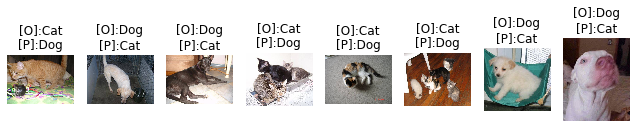

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ps, xs, ys = get_images(x_test, y_test, 100)
accu = model.evaluate(xs, ys)[1]
print("命中率:", accu * 100, "%")
# 如果是使用Model, 而不是Sequential的話
# 你會沒有 predict_classes
# 你要用predict + argmax來替代
pre = model.predict(xs).argmax(axis=1)

x_test = np.array(list(map(lambda p:np.array(load_img(p)), ps)))
idx = np.nonzero(pre != ys)[0][:200]
pre_false_img = x_test[idx]
pre_false_label = ys[idx]
pre_false_pre = pre[idx]

width = 10
height = len(idx) // width + 1
plt.figure(figsize=(14, 42))

trans = ["Cat", "Dog"]
z = zip(pre_false_img, pre_false_label, pre_false_pre)
# (i, (z1, z2, z3))
for i, (img, label, p) in enumerate(z):
    plt.subplot(height, width, i+1)
    plt.title("[O]:{}\n[P]:{}".format(trans[label], trans[p]))
    plt.axis("off")
    plt.imshow(img)